# Train model based on VGGish features

__VGGish__: 128-dimensional audio features extracted at 1Hz. The audio features were extracted using a VGG-inspired acoustic model described in Hershey et. al., trained on a preliminary version of YouTube-8M. The features were PCA-ed and quantized to be compatible with the audio features provided with YouTube-8M. They are stored as TensorFlow Record files.

To my understanding: VGGish model turns audio classification problems into image classification problems. They create 2D image-like patches by computing log-mel spectrograms of multiple frames, and feed that into models. The input thus become some transformations of visual representation of spectrum of frequencies of the signal as it changes with time.

Reference: https://arxiv.org/pdf/1609.09430.pdf

__PCA__: Two primary reasons for use
- Data reduction: condense the information contained in a large number of original variables into a smaller set of new composite dimensions, with a minimum loss of information.
- Interpretation: discover important features of a large data set that often reveals relationships that were previously unsuspected, thereby allowing interpretations that would not ordinarily result.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from shutil import *

In [2]:
# The directory should be arranged in form:
# .
# ├── audioset_v1_embeddings
# ├── class_labels_indices.csv
# └── Model_on_VGG.ipynb

path = "audioset_v1_embeddings/"
eva = "eval/"
bal = "bal_train/"
unbal = "unbal_train/"

-------------------------------
-------------------------------
-------------------------------
-------------------------------

## 1: convert .tfrecord info into .csv 

In [3]:
index_label = pd.read_csv("class_labels_indices.csv")

In [4]:
def map_index_to_label(index_label, index):
    # Maps index to readable labels
    # Return label is a list, that could contain more than 1 item, but refer to the same label
    # Return labels are all in lower form, no CAP
    # e.g. ['male speech', 'man speaking']
    #
    # input: pandas.DataFrame index_to_label_df, int index
    # output: list readable_label
    
    # Get the real index of df, in case of mismatch
    index = index_label.loc[index_label['index'] == index].index[0] 
    labels = [label.strip().lower() for label in index_label.iloc[index]['display_name'].split(",")]
    return labels

In [5]:
def map_label_to_index(index_label, label):
    # Maps readable labels to index
    #
    # input: pandas.DataFrame index_to_label_df, str label
    # output: int index
    label = label.lower()
    labelCap = label.capitalize()
    for index, row in index_label.iterrows():
        labels = [label.strip() for label in row['display_name'].split(",")]
        if label in labels or labelCap in labels:
            return index_label.iloc[index]['index']
    return -1

In [6]:
def read_tfrecord(filename):
    # Read in a tfrecord file
    # Store information in list of lists
    # Audio_embedding is a list of 10 embeddings, each represents 1 second feature
    #
    # input: str filename
    # output: pandas dataframe with columns:
    #        [str video_id, float start_time, float end_time, list label_index, list embed]
    
    if not filename.endswith('.tfrecord'):
        print("This file is not a .tfrecord file.")
        return
    raw_dataset = tf.data.TFRecordDataset(filename)
    return_df = pd.DataFrame(columns=
                             ['video_id', 'start_time_seconds', 'end_time_seconds', 'labels', 'audio_embedding'])
    for raw_record in raw_dataset:
        cur_record_list = []
        example = tf.train.SequenceExample()
        example.ParseFromString(raw_record.numpy())
        
        cur_record_list.append(example.context.feature['video_id'].bytes_list.value[0].decode("utf-8"))
        cur_record_list.append(example.context.feature['start_time_seconds'].float_list.value[0])
        cur_record_list.append(example.context.feature['end_time_seconds'].float_list.value[0])
        cur_record_list.append(example.context.feature['labels'].int64_list.value)
        
        # Original embeddings are stored in hex format, now convert them to readable int
        embeds = []
        for i in range(len(example.feature_lists.feature_list['audio_embedding'].feature)):
            hexembed = example.feature_lists.feature_list['audio_embedding'].feature[i].bytes_list.value[0].hex()
            arrayembed = [int(hexembed[i:i+2], 16) for i in range(0, len(hexembed), 2)]
            embeds.append(arrayembed)
        cur_record_list.append(embeds)
        
        return_df.loc[len(return_df)] = cur_record_list
    return return_df

In [7]:
def convert_csv_tfrecord_dir(dir_path, dest):
    # Read and concat all tfrecord files in a directory
    # and save to csv in appending mode
    #
    # input: str directory_path, (must contain '/' in the end, e.g. 'unbal_train/')
    # output: int count_tfrecord_files
    cnt = 0
    for file in os.listdir(dir_path):
        if file.endswith(".tfrecord"):
            df = read_tfrecord(dir_path+file)
            # Original method, that read all data into a df, then store it as csv
            # takes too much RAM, and causes crashes when reach limit
            # Now update to batch save to avoid exploding uses of RAM
            # But still, CPU usage is too high, hope to upgrade later
            if cnt == 0:
                df.to_csv(dest, index=False, header=True)
            else:
                df.to_csv(dest, mode='a', index=False, header=False)
            cnt += 1
    return cnt

In [8]:
# convert_csv_tfrecord_dir(path+eva, path+'eval.csv')

In [9]:
# convert_csv_tfrecord_dir(path+bal, path+'bal.csv')

In [10]:
# Takes a looooooooooong time!
# convert_csv_tfrecord_dir(path+unbal, path+'unbal.csv')

-------------------------------
-------------------------------
-------------------------------
-------------------------------

## 2: prepare data for model training

In [11]:
eval_info = pd.read_csv(path+"eval.csv")
bal_info = pd.read_csv(path+"bal.csv")
unbal_info = pd.read_csv(path+"unbal.csv")

In [12]:
eval_info.head()

,video_id,start_time_seconds,end_time_seconds,labels,audio_embedding
0,2Hj6ogt1TJo,80.0,90.0,"[86, 90, 91]","[[42, 94, 128, 51, 200, 113, 115, 50, 169, 120..."
1,2HZcxlRs-hg,30.0,40.0,"[300, 316, 319]","[[0, 255, 0, 0, 179, 248, 255, 106, 50, 73, 95..."
2,wRgH7HvmSiE,30.0,40.0,"[46, 485]","[[100, 65, 207, 138, 118, 81, 146, 35, 219, 16..."
3,wRKCb1rOGT8,40.0,50.0,[420],"[[49, 255, 0, 0, 122, 236, 115, 51, 223, 203, ..."
4,wRvtuIFoqCM,170.0,180.0,"[423, 476]","[[35, 83, 161, 88, 201, 166, 42, 110, 132, 212..."


In [13]:
def get_df_with_label(df, label):
    # Create a sub-df from df where labeled as <label>
    #
    # input: df df, label string
    # output: df df_elements_with_<label>
    index = map_label_to_index(index_label, label)
    # labels read from csv file become str instead of list
    mask = df.labels.apply(lambda x: True if index in [int(l) for l in x[1:-1].split(',')] else False)
    df1 = df[mask]
    return df1

In [14]:
def drop_sub_df(df, df_subset):
    # (df - df_subset), where df_subset is a subset of df
    # 
    # input: df df, df subset_of_df
    # output: df 
    df_new = df.merge(df_subset, how='left', indicator=True)
    df_new = df_new[df_new['_merge'] == 'left_only']
    del df_new['_merge']
    return df_new

In [15]:
def df_sample(df, size):
    # Get a subset from df, where contains n elemets, randomly sampled from df
    #
    # input: df df, size number_of_elements_in_subset
    # output: df
    return df.sample(n = size) 

In [16]:
def df_add_col_with_value(df, col_name, value):
    # Add a column to given df with specified value
    #
    # input: df df, col_name column_name, value default_value_of_new_column
    # output: df df
    df[col_name] = value
    return df

def get_xy_from_df(df, norm=False):
    # Return the value of specific column as list
    # Do something different to 'audio_embedding', turn list of strs to list of ints
    #
    # input: df df, col_name column_name
    # output: list column_values
    total = df['audio_embedding'].tolist()
    total_y = df['y'].tolist()
    ret = []
    ret_y = []
    for index, embeds_10s in enumerate(total):
        tmp = embeds_10s[1:-1]
        tmp = tmp.replace(',', ' ').split(']')
        for i, embed_1s in enumerate(tmp):
            if embed_1s == '':
                continue
            embed_1s_reform = embed_1s.replace('[', '').strip().split()
            if norm:
                ret.append([int(num)/255 for num in embed_1s_reform])
            else:
                ret.append([int(num) for num in embed_1s_reform])
            if total_y[index] == 0:
                ret_y.append([1, 0])
            else:
                ret_y.append([0, 1])
                
            # Allow break to get only the first second features
#             break
    return ret, ret_y

In [22]:
def get_test_xy_from_df(df, norm=False):
    # Return the value of specific column as list
    # Do something different to 'audio_embedding', turn list of strs to list of ints
    #
    # input: df df, col_name column_name
    # output: list column_values
    total = df['audio_embedding'].tolist()
    total_y = df['y'].tolist()
    ret = []
    ret_y = []
    for index, embeds_10s in enumerate(total):
        tmp = embeds_10s[1:-1]
        tmp = tmp.replace(',', ' ').split(']')
        add_bracket_x = []
        add_bracket_y = []
        for i, embed_1s in enumerate(tmp):
            if embed_1s == '':
                continue
            embed_1s_reform = embed_1s.replace('[', '').strip().split()
            if norm:
                add_bracket_x.append([int(num)/255 for num in embed_1s_reform])
            else:
                add_bracket_x.append([int(num) for num in embed_1s_reform])
            if total_y[index] == 0:
                add_bracket_y.append([1, 0])
            else:
                add_bracket_y.append([0, 1])
                
        ret.append(add_bracket_x)
        ret_y.append(add_bracket_y)
    return ret, ret_y


In [17]:
def df_get_labelled_unlabelled(df, label, ratio_of_label_unlabel):
    # Create a new df, that contains all rows with <label>
    # and n * len(<label>) rows without <label>
    # The new df contains a new columns that indicate whether contain <label>
    #
    # input: df df, str label, int ratio_of_label:unlabel
    # output: df new_df
    labelled = get_df_with_label(df, label)
    unlabelled = drop_sub_df(df, labelled)
    unlabelled = df_sample(unlabelled, len(labelled) * ratio_of_label_unlabel)
    labelled = df_add_col_with_value(labelled, 'y', 1)
    unlabelled = df_add_col_with_value(unlabelled, 'y', 0)
    new_df = pd.concat([labelled, unlabelled],ignore_index=True)
    # Shuffle df
    new_df = new_df.iloc[np.random.permutation(len(new_df))]
    return new_df

In [23]:
def balance_df_size(dfs, a, b, c):
    # Rebalance the size of three dataframes train, val, test
    # Reset the ratio of train:val:test to a:b:c
    # Keep the original ratio of label:unlabel in new dfs
    #
    # input: list[df] dfs, int a, int b, int c
    # output: list[df] rebalanced_dfs
    total = pd.concat(dfs, ignore_index=True)
    labeled = total.loc[total['y'] == 1]
    unlabeled = drop_sub_df(total, labeled)
    
    train_labeled = labeled.sample(frac=(a/(a+b+c)))
    tmp_labeled = drop_sub_df(labeled, train_labeled)
    val_labeled = tmp_labeled.sample(frac=(b/(b+c)))
    test_labeled = drop_sub_df(tmp_labeled, val_labeled)
    
    train_unlabeled = unlabeled.sample(frac=(a/(a+b+c)))
    tmp_unlabeled = drop_sub_df(unlabeled, train_unlabeled)
    val_unlabeled = tmp_unlabeled.sample(frac=(b/(b+c)))
    test_unlabeled = drop_sub_df(tmp_unlabeled, val_unlabeled)
    
    train = pd.concat([train_labeled, train_unlabeled], ignore_index=True).sample(frac=1)
    val = pd.concat([val_labeled, val_unlabeled], ignore_index=True).sample(frac=1)
    test = pd.concat([test_labeled, test_unlabeled], ignore_index=True).sample(frac=1)
    return [train, val, test]

def data_for_model(dfs, label, ratio_of_label_unlabel, a=0, b=0, c=0, norm=False):
    # Combine previous functions and form x, y value lists for model
    # Return train_x/y, val_x/y, test_x/y, in one call
    # ratio_of_label_unlabel is used for df_get_labelled_unlablled, as the ratio of label:unlabel
    # a, b, c is ratio of train:val:test, if they are not specified, then do not modify
    # norm decide whether normalize the embeddings.
    #
    # input: list[df] dfs, str label, int ratio_of_label:unlabel, int a, int b, int c, bool norm
    # output: lists train/val/test_x/y
    train = df_get_labelled_unlabelled(dfs[0], label, ratio_of_label_unlabel)
    val = df_get_labelled_unlabelled(dfs[1], label, ratio_of_label_unlabel)
    test = df_get_labelled_unlabelled(dfs[2], label, ratio_of_label_unlabel)
    
    if a!=0 or b!=0 or c!=0:
        train, val, test = balance_df_size([train, val, test], a, b, c)
        
    train_x, train_y = get_xy_from_df(train, norm=norm)
    val_x, val_y = get_xy_from_df(val, norm=norm)
#     test_x, test_y = get_xy_from_df(test, norm=norm)
    test_x, test_y = get_test_xy_from_df(test, norm=norm)
    return train_x, train_y, val_x, val_y, test_x, test_y

In [24]:
def visualize_training(history, filename):
    # Visulize training result
    #
    # input: history output_of_model.fit
    # output: None
    history_dict = history.history
    history_dict.keys()
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    
    # "bo" is for "blue dot"
    ax1.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(epochs, acc, 'bo', label='Training acc')
    ax2.plot(epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')
    
    plt.show()
#     plt.savefig(filename, bbox_inches='tight')

def print_test_result(model, test_x, text_y):
    results = model.evaluate(test_x, test_y, verbose=2)
    for name, value in zip(model.metrics_names, results):
        print("%s: %.3f" % (name, value))

In [20]:
def find_pic_with_keyword(src_dirs, dst_dir, keywords):
    # Copy the targeted files from src_dirs to dst_dir
    # Eg. find_pic_with_keyword(['results1/', 'results3/'], 'tmp/', ['1_elu_'])
    # dirs must contain '/' in the end
    # 
    # input: list[str] src_dirs, str dst_dir, list[str] keywords
    # output: None
    rmtree(dst_dir)
    os.mkdir(dst_dir)
    for src_dir in src_dirs:
        files = [f for f in listdir(src_dir) if isfile(join(src_dir, f))]
        mov_files = [f for f in files if all(k in f for k in keywords)]
        for f in mov_files:
            copyfile(src_dir+f, dst_dir+f)

-------------------------------
-------------------------------
-------------------------------
-------------------------------

## 3.1: build and train model [exploration]
### First trial: 
Focus on balanced data input, where ratio is set to 1.  
Check results1/README.md for detail information:  
https://github.com/googleinterns/activity-recognition/blob/snore-AudioPrep/snore/VGG/results1/README.md

In [19]:
def model_config_train_1(data, activation, optimizer, metrics, epochs):
    # Get train, val, test sets, and config to train model
    #
    # input: list[list] data, str activation, str optimizer, list[str] metrics, int epochs
    # output: history output_of_model.fit
    train_x, train_y, val_x, val_y, test_x, test_y = data
    
    model = keras.Sequential([
        keras.Input(shape=(128,)),
        keras.layers.Dense(128, activation=activation),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=metrics)
    history = model.fit(train_x, train_y,
                   epochs=epochs,
                   validation_data=(val_x, val_y),
                    verbose=1)
    return history

In [ ]:
ratio_list = [1, 20, 40]
activation_list = ['elu', 'exponential', 'relu', 'selu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh']
optimizer_list = ['adadelta', 'adagrad', 'adam', 'adamax', 'ftrl', 'nadam', 'rmsprop', 'sgd']
metrics_list = [['accuracy']]
epochs_list = [20, 30, 40, 50]

for ratio in ratio_list:
    data = data_for_model([unbal_info, bal_info, eval_info], 'snoring', ratio)
    for activation in activation_list:
        for optimizer in optimizer_list:
            for metrics in metrics_list:
                for epochs in epochs_list:
                    history = model_config_train_1(data, activation, optimizer, metrics, epochs)
                    visualize_training(history, 
                                       'results1/'+str(ratio)+'_'+activation+'_'+
                                       optimizer+'_'+'_'.join(metrics)+'_'+str(epochs)+'.png')

-------------------------------
-------------------------------
-------------------------------
-------------------------------

## 3.2: build and train model [increase val size]
### Second trial: 
__Set train : val : test to 8 : 1 : 1__  
__Give unbalanced data for training, in order to get larger training size.__  
Check results2/README.md for detail information:  
https://github.com/googleinterns/activity-recognition/blob/snore-AudioPrep/snore/VGG/results2/README.md

In [28]:
def model_config_train_2(data, activation, optimizer, metrics, epochs):
    # Get train, val, test sets, and config to train model
    #
    # input: list[list] data, str activation, str optimizer, list[str] metrics, int epochs
    # output: history output_of_model.fit
    train_x, train_y, val_x, val_y, test_x, test_y = data
    
    model = keras.Sequential([
        keras.Input(shape=(128,)),
        keras.layers.Dense(128, activation=activation),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=metrics)
    history = model.fit(train_x, train_y,
                   epochs=epochs,
                   validation_data=(val_x, val_y),
                    verbose=1)
    return history

In [ ]:
ratio_list = [1, 10]
activation_list = ['elu', 'relu', 'selu', 'sigmoid', 'softsign', 'tanh']
optimizer_list = ['adagrad', 'adam', 'adamax', 'ftrl', 'nadam', 'rmsprop']
metrics_list = [['accuracy']]
epochs_list = [20, 40, 60, 80, 100]

for ratio in ratio_list:
    data = data_for_model([unbal_info, bal_info, eval_info], 'snoring', ratio, a=8, b=1, c=1)
    for activation in activation_list:
        for optimizer in optimizer_list:
            for metrics in metrics_list:
                for epochs in epochs_list:
                    history = model_config_train_2(data, activation, optimizer, metrics, epochs)
                    visualize_training(history, 
                                       'results2/'+str(ratio)+'_'+activation+'_'+
                                       optimizer+'_'+'_'.join(metrics)+'_'+str(epochs)+'.png')

-------------------------------
-------------------------------
-------------------------------
-------------------------------

## 3.3: build and train model [normalization]
### Third trial: 
__Since VGG turns audio problem to image problem, the 128-dimension embeddings are at range [0, 255]. Should be better if we normalize them.__  
__Train : val : test = 8 : 1 : 1__  
Check results3/README.md for detail information:  
https://github.com/googleinterns/activity-recognition/blob/snore-AudioPrep/snore/VGG/results3/README.md

In [24]:
def model_config_train_3(data, activation, optimizer, metrics, epochs):
    # Get train, val, test sets, and config to train model
    #
    # input: list[list] data, str activation, str optimizer, list[str] metrics, int epochs
    # output: history output_of_model.fit
    train_x, train_y, val_x, val_y, test_x, test_y = data
    
    model = keras.Sequential([
        keras.Input(shape=(128,)),
        keras.layers.Dense(128, activation=activation),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=metrics)
    history = model.fit(train_x, train_y,
                   epochs=epochs,
                   validation_data=(val_x, val_y),
                    verbose=1)
    return history

In [ ]:
ratio_list = [1]
activation_list = ['elu', 'exponential', 'relu', 'selu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh']
optimizer_list = ['adadelta', 'adagrad', 'adam', 'adamax', 'ftrl', 'nadam', 'rmsprop', 'sgd']
metrics_list = [['accuracy']]
epochs_list = [30, 50]

for ratio in ratio_list:
    data = data_for_model([unbal_info, bal_info, eval_info], 
                          'snoring', 1, a=8, b=1, c=1, norm=True)
    for activation in activation_list:
        for optimizer in optimizer_list:
            for metrics in metrics_list:
                for epochs in epochs_list:
                    history = model_config_train_3(data, activation, optimizer, metrics, epochs)
                    visualize_training(history, 
                                       'results3/trail3_'+str(ratio)+'_'+activation+'_'+
                                       optimizer+'_'+'_'.join(metrics)+'_'+str(epochs)+'.png')

In [51]:
find_pic_with_keyword(['results1/', 'results3/'], 'tmp/', ['_softsign_'])

-------------------------------
-------------------------------
-------------------------------
-------------------------------

## 3.4: fixed a bug in importing tfrecord, get 10 times more data!!!
### Fourth trial: 
__Found a bug in importing .tfrecord, now we get 10 TIMES MORE data for training, validating, and testing!!!!__  
__Eval.csv, bal.csv, and unbal.csv have been changed directly, so previous trials could not be repeated with original configuration after this commit.__  
__Train : val : test = 7 : 2 : 1__  
__Train: 35850, val: 10228, test: 5105__  
Check results4/README.md for detail information:  
https://github.com/googleinterns/activity-recognition/blob/snore-AudioPrep/snore/VGG/results4/README.md

In [103]:
def model_config_train_4(data, activation, optimizer, metrics, epochs):
    # Get train, val, test sets, and config to train model
    #
    # input: list[list] data, str activation, str optimizer, list[str] metrics, int epochs
    # output: history output_of_model.fit
    train_x, train_y, val_x, val_y, test_x, test_y = data
    train_x = np.asarray(train_x)
    train_y = np.asarray(train_y)
    
    model = keras.Sequential([
        keras.Input(shape=(128,)),
        keras.layers.Dense(128, activation=activation),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=metrics)
    history = model.fit(train_x, train_y,
                   epochs=epochs,
                   validation_data=(val_x, val_y),
                    verbose=1)
    return history

In [ ]:
ratio_list = [1]
activation_list = ['elu', 'exponential', 'relu', 'selu', 'sigmoid', 'softplus', 'softsign']
optimizer_list = ['adagrad', 'adam', 'adamax', 'sgd']
metrics_list = [['accuracy']]
epochs_list = [50]

for ratio in ratio_list:
    data = data_for_model([unbal_info, bal_info, eval_info], 
                          'snoring', 1, a=7, b=2, c=1, norm=True)
    for activation in activation_list:
        for optimizer in optimizer_list:
            for metrics in metrics_list:
                for epochs in epochs_list:
                    history = model_config_train_4(data, activation, optimizer, metrics, epochs)
                    visualize_training(history, 
                                       'results4/trail4_'+str(ratio)+'_'+activation+'_'+
                                       optimizer+'_'+'_'.join(metrics)+'_'+str(epochs)+'.png')

-------------------------------
-------------------------------
-------------------------------
-------------------------------

## 3.5: Based on previous trial, add one more hidden layer and dropout.
### Fifth trial: 
__Found a bug in importing .tfrecord, now we get 10 TIMES MORE data for training, validating, and testing!!!!__  
__Eval.csv, bal.csv, and unbal.csv have been changed directly, so previous trials could not be repeated with original configuration after this commit.__  
__Train : val : test = 7 : 2 : 1__  
__Train: 35850, val: 10228, test: 5105__  
__Add one more hidden layer and dropout for training!__
Check results5/README.md for detail information:  
https://github.com/googleinterns/activity-recognition/blob/snore-AudioPrep/snore/VGG/results5/README.md

In [110]:
def model_config_train_5(data, activation, optimizer, metrics, epochs):
    # Get train, val, test sets, and config to train model
    #
    # input: list[list] data, str a,ctivation, str optimizer, list[str] metrics, int epochs
    # output: history output_of_model.fit
    train_x, train_y, val_x, val_y, test_x, test_y = data
    
    model = keras.Sequential([
        keras.Input(shape=(128,)),
        keras.layers.Dense(128, activation=activation),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(128, activation=activation),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=metrics)
    history = model.fit(train_x, train_y,
                   epochs=epochs,
                   validation_data=(val_x, val_y),
                    verbose=1)
    return history

In [ ]:
ratio_list = [1]
activation_list = ['elu', 'exponential', 'relu', 'selu', 'sigmoid', 'softplus', 'softsign']
optimizer_list = ['adagrad', 'adamax', 'sgd']
metrics_list = [['accuracy']]
epochs_list = [50]

for ratio in ratio_list:
    data = data_for_model([unbal_info, bal_info, eval_info], 
                          'snoring', 1, a=7, b=2, c=1, norm=True)
    for activation in activation_list:
        for optimizer in optimizer_list:
            for metrics in metrics_list:
                for epochs in epochs_list:
                    history = model_config_train_5(data, activation, optimizer, metrics, epochs)
                    visualize_training(history, 
                                       'results5/trail5_'+str(ratio)+'_'+activation+'_'+
                                       optimizer+'_'+'_'.join(metrics)+'_'+str(epochs)+'.png')

-------------------------------
-------------------------------
-------------------------------
-------------------------------

## 3.6: F-1 score, and Summarize
### Sixth trial: 
__Train : val : test = 7 : 2 : 1__  
Check update slide for more information:  
https://docs.google.com/presentation/d/13jRJk06FwlfLtGMcOjuNT6Xc3JN7k-MCQ62sM2QJ6t0/edit?ts=5eeaa13f#slide=id.g8a6f6f1371_1_36

In [130]:
def TP_FN_FP_TN(model, test_x, test_y):
    pos_x, pos_y = [], []
    neg_x, neg_y = [], []
    for x, y in zip(test_x, test_y):
        if y == [1, 0]:
            neg_x.append(x)
            neg_y.append(y)
        else:
            pos_x.append(x)
            pos_y.append(y)

    acc_pos = model.evaluate(pos_x, pos_y)[1]
    acc_neg = model.evaluate(neg_x, neg_y)[1]

    TP = acc_pos * len(pos_y)
    FN = len(pos_y) - TP
    TN = acc_neg * len(neg_y)
    FP = len(neg_y) - TN
    return TP, FN, FP, TN

def precision(TP, FP):
    if (TP + FP) == 0:
        return 0
    return TP / (TP + FP)

def recall(TP, FN):
    if (TP + FN) == 0:
        return 0
    return TP / (TP + FN)

def f1_score(model, test_x, test_y):
    TP, FN, FP, TN = TP_FN_FP_TN(model, test_x, test_y)
    prec = precision(TP, FP)
    rec = recall(TP, FN)
    if (prec + rec) == 0:
        return 0
    return (2 * prec * rec) / (prec + rec)


In [27]:
def model_config_train_6(data, activation, optimizer, metrics, epochs):
    # Get train, val, test sets, and config to train model
    #
    # input: list[list] data, str a,ctivation, str optimizer, list[str] metrics, int epochs
    # output: history output_of_model.fit
    train_x, train_y, val_x, val_y, test_x, test_y = data
    
    model = keras.Sequential([
        keras.Input(shape=(128,)),
        keras.layers.Dense(128, activation=activation),
        keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer=optimizer,
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=metrics)
    history = model.fit(train_x, train_y,
                   epochs=epochs,
                   validation_data=(val_x, val_y),
                    verbose=1)
    return model, history


In [ ]:
ratio_list = [1]
activation_list = ['elu', 'exponential', 'relu', 'selu', 'sigmoid', 'softplus', 'softsign']
optimizer_list = ['adagrad', 'adamax', 'sgd']
metrics_list = [['accuracy']]
epochs_list = [50]

accs = [[0 for i in range(3)] for j in range(7)]
f1s = [[0 for i in range(3)] for j in range(7)]

for ratio in ratio_list:
    data = data_for_model([unbal_info, bal_info, eval_info], 
                          'snoring', 1, a=7, b=2, c=1, norm=True)
    for i, activation in enumerate(activation_list):
        for j, optimizer in enumerate(optimizer_list):
            for metrics in metrics_list:
                for epochs in epochs_list:
                    model, history = model_config_train_6(data, activation, optimizer, metrics, epochs)
                    accs[i][j] = model.evaluate(data[4], data[5])[1]
                    f1s[i][j] = f1_score(model, data[4], data[5])

In [241]:
accs_4668_data = [[0.8819742202758789, 0.8798283338546753, 0.8755365014076233],
 [0.8648068904876709, 0.8776823878288269, 0.5],
 [0.8776823878288269, 0.8841201663017273, 0.8712446093559265],
 [0.8841201663017273, 0.8776823878288269, 0.8733905553817749],
 [0.8648068904876709, 0.8733905553817749, 0.7725321650505066],
 [0.8776823878288269, 0.8819742202758789, 0.8648068904876709],
 [0.8755365014076233, 0.8733905553817749, 0.8776823878288269]]

In [243]:
f1s_4668_data = [[0.8827292099509372, 0.8793103541164491, 0.876068369093492],
 [0.8662420611292093, 0.8779443388545746, 0.6666666666666666],
 [0.8794926160656253, 0.8815789425595977, 0.8706896569785816],
 [0.8846153777673162, 0.8814968654096738, 0.8763102721704604],
 [0.8656716329517344, 0.87682672040127, 0.7546296396014243],
 [0.8768898318384413, 0.8837209329638394, 0.8662420611292093],
 [0.876595736130593, 0.8685968822354627, 0.8774193698682596]]

In [268]:
accs_46562_one_layer = [[0.8974413871765137, 0.9073317646980286, 0.9015265703201294],
 [0.8998064994812012, 0.9075467586517334, 0.9019565582275391],
 [0.8976564407348633, 0.9032466411590576, 0.9032466411590576],
 [0.8983014225959778, 0.9062567353248596, 0.9038916230201721],
 [0.8894861340522766, 0.9047516584396362, 0.892066240310669],
 [0.8955063223838806, 0.9023866057395935, 0.9008815288543701],
 [0.8959363698959351, 0.9090518355369568, 0.9008815288543701]]

In [270]:
f1s_46562_one_layer = [[0.8988763982075502, 0.9087444536045154, 0.9028837920439335],
 [0.9006820276373813, 0.9109730767541692, 0.9003496577322799],
 [0.8988954879043034, 0.9049831078909455, 0.9048625885492108],
 [0.8995966935819611, 0.9058315179470764, 0.9040978512276161],
 [0.8903583565908131, 0.9068740785436292, 0.8940481215183268],
 [0.8969028228666714, 0.9058091190553039, 0.9022683969888552],
 [0.8971525905463413, 0.9104382689015164, 0.9023098123162445]]

In [261]:
accs_46562_two_layers = [[0.8869995474815369, 0.877098560333252, 0.8882910013198853],
 [0.8775290846824646, 0.8727937936782837, 0.8833405375480652],
 [0.8811880946159363, 0.883986234664917, 0.8854929208755493],
 [0.8872147798538208, 0.8897976875305176, 0.8897976875305176],
 [0.8792509436607361, 0.8861386179924011, 0.8777443170547485],
 [0.8790357112884521, 0.8792509436607361, 0.8831252455711365],
 [0.8835557699203491, 0.8835557699203491, 0.8880757689476013]]

In [263]:
f1s_46562_two_layers = [[0.8919085841487128, 0.8858228372310146, 0.8927020914379193],
 [0.8820725460580519, 0.8821065220460308, 0.8896130445280507],
 [0.8861386106390824, 0.8907801304690514, 0.8909836242566206],
 [0.8918249322331252, 0.8907849941893498, 0.8935108137231943],
 [0.8844014078942111, 0.891797930863911, 0.8827415470151199],
 [0.884362165312692, 0.8869179513955247, 0.887274226349159],
 [0.8890256502154249, 0.8886602231644948, 0.8928718671192077]]

In [288]:
def print_pretty(lst):
    for i in lst:
        print("%.3f\t%.3f\t%.3f" % (i[0], i[1], i[2]))

In [294]:
print_pretty(f1s_46562_two_layers)

0.892	0.886	0.893
0.882	0.882	0.890
0.886	0.891	0.891
0.892	0.891	0.894
0.884	0.892	0.883
0.884	0.887	0.887
0.889	0.889	0.893


-------------------------------
-------------------------------
-------------------------------
-------------------------------

## 3.7: Test considering larger frames
### Seventh trial: 
Previously, train/test only happen on 1s frames.  
Now considering larger frames, for example 3s. The prediction of 3s would be majority of 1s predictions.

#### Comparison with the same data chosen
__Previous conclusion is drawn from different data (in order to have balanced data, we have a random chosen process inside), this time we do comparison with the same data__  

| Same audio chosen | 4000 data + 1 layer | 40000 data + 1 layer | 40000 data + 2 layers |
|-------------------|---------------------|----------------------|-----------------------|
| precision         | 0.913               | 0.932                | 0.912                 |
| recall            | 0.819               | 0.831                | 0.848                 |
| f1-score          | 0.86                | 0.878                | 0.879                 |

Conclusion the same as 3.6

--------------

#### Comparison using multiple seconds combination for testing results
__Previous tests are on 1s base, now, we use voting strategy, to have multiple seconds as frame base__  
That is, e.g, for 3s results [pos, pos, neg], we choose the highest voting, which is pos in this case.  
If count(pos) == count(neg), we mark it as pos.  

|           | 1s    | 2s    | 3s    | 4s    | 5s    | 6s    | 7s    | 8s    | 9s    | 10s   |
|-----------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| precision | 0.921 | 0.968 | 0.945 | 0.966 | 0.95  | 0.965 | 0.954 | 0.963 | 0.953 | 0.966 |
| recall    | 0.84  | 0.896 | 0.855 | 0.88  | 0.858 | 0.874 | 0.851 | 0.869 | 0.852 | 0.862 |
| f1-score  | 0.879 | 0.931 | 0.897 | 0.921 | 0.901 | 0.917 | 0.899 | 0.914 | 0.899 | 0.911 |



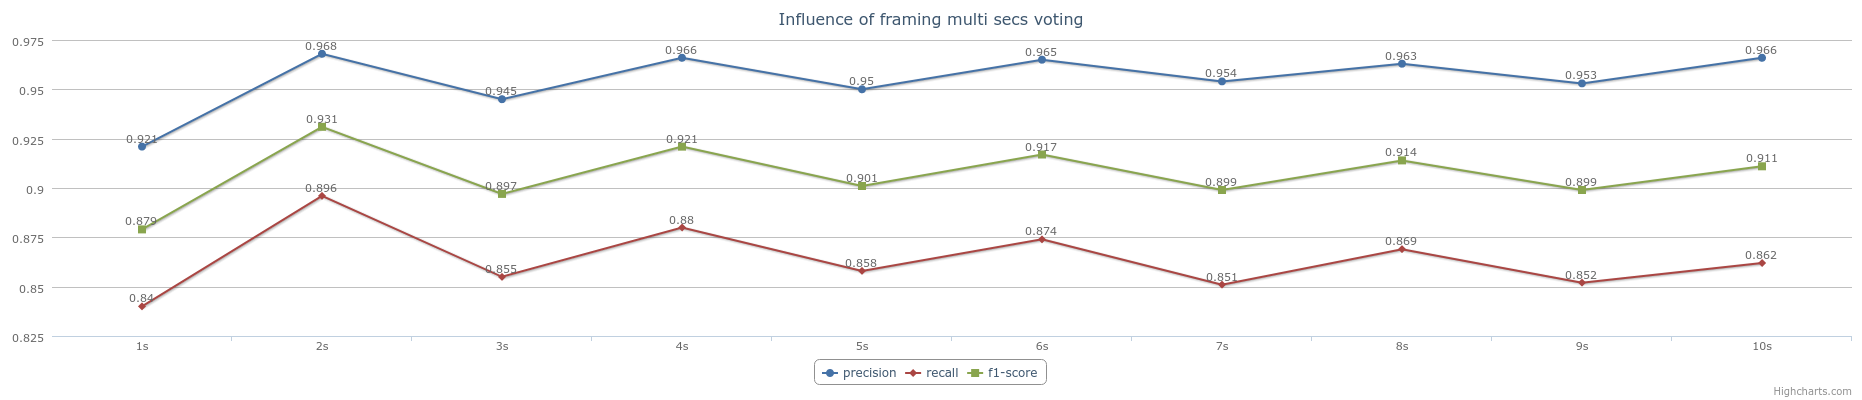

In [304]:
# Check the image in results7/ for a clearer view
from IPython.display import Image
Image("results7/multi_secs_voting.png")

In [357]:
train_x, train_y, val_x, val_y, test_x, test_y = data_for_model([unbal_info, bal_info, eval_info], 
                                                                'snoring', 1, a=7, b=2, c=1, norm=True)

/usr/local/google/home/ohjerry/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:

model = keras.Sequential([
    keras.Input(shape=(128,)),
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adamax',
         loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
         metrics=['accuracy'])
history = model.fit(train_x, train_y,
               epochs=50,
               validation_data=(val_x, val_y),
                verbose=1)

In [359]:
model.predict(test_x[0])

array([[9.9998689e-01, 1.3088930e-05],
       [9.9997640e-01, 2.3565895e-05],
       [9.9996531e-01, 3.4708650e-05],
       [9.9966681e-01, 3.3314916e-04],
       [9.9972636e-01, 2.7359722e-04],
       [9.9999976e-01, 2.5653668e-07],
       [9.9999166e-01, 8.3293817e-06],
       [9.9999881e-01, 1.2415322e-06],
       [9.9999809e-01, 1.9109143e-06],
       [9.9999893e-01, 1.0730887e-06]], dtype=float32)

In [360]:
res = []
for clip_index, clip in enumerate(test_x):
    pred = model.predict(clip) > 0.5
    real = test_y[clip_index][0]
    lst = []
    for sec_index, sec in enumerate(pred):
        sec = list(sec)
        lst.append(sec == real)
    res.append(lst)

In [361]:
def frameN(lst, n):
    res = []
    for line in lst:
        if n >= len(line):
            res.append([sum(line) >= len(line)/2])
        else:
            tmp = []
            for i in range(len(line)-n+1):
                sub = line[i: i+n]
                tmp.append(sum(sub) >= len(sub)/2)
            res.append(tmp)
    return res

In [362]:
n = 2
reframed = frameN(res, n)

In [363]:
TP, FN, TN, FP = 0, 0, 0, 0
for clip_index, clip in enumerate(reframed):
    pos = test_y[clip_index][0] == [0, 1]
    for pred in clip:
        if pos == True and pred == True:
            TP += 1
        if pos == True and pred == False:
            FP += 1
        if pos == False and pred == True:
            TN += 1
        if pos == False and pred == False:
            FN += 1

prec = precision(TP, FP)
rec = recall(TP, FN)
if (prec + rec) == 0:
    f1 = 0
else:
    f1 = (2 * prec * rec) / (prec + rec)

print(round(prec,3))
print(round(rec,3))
print(round(f1,3))

0.961
0.931
0.946
